# Pair Trading Strategy Research

Armaan Gandhara | agandhara243@gmail.com | armaangandhara.me

09/2025

## Config & Utils

*Purpose* : Centeralized parameters, imports, styles, and small helpers reused across the notebook. This keeps later sections focused on research and backtesting logic, not boilerplate

Whats inside:
- Project config (Config dataclass): dates, universe, paths, risk-free, frequency
- Reproducibility: seed setter
- Plot style: consistent figures 
- Helpers: annualizer factor, returns, rolling z-score, drawdown and risk metrics, alignment utilities
- Lightweight disk cache utility for later data ingest

### Code

In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
import os
import json
import hashlib
import warnings
from typing import Iterable, Tuple, Optional, Dict
import random
import requests
from datetime import datetime
from itertools import combinations


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from ibfetcher import IBFetcher
from utils import save_to_csv

warnings.filterwarnings("ignore")

In [3]:
# =======================
# Config & Utils
# =======================

# ---------- Config ----------

@dataclass
class Config:
    start:str
    end:str
    tickers:Iterable[str]
    data_dir: str = "data"
    freq: str = "D"
    trading_days: int = 252
    rf_annual: float = 0.00

    def path(self):
        p = Path(self.data_dir)
        p.mkdir(parents=True, exist_ok=True)
        (p/"cache").mkdir(parents=True, exist_ok=True)
        return p
    
# ---------- Repro/Style ----------

def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)

def set_plot_style():
    plt.rcParams.update({
        "figure.figsize": (10,5),
        "axes.grid":True,
        "grid.alpha": 0.3,
        "font.size": 11,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

# ---------- Frequencies/Annualization ----------

_ANNUALIZE = {
    "D": 252,
    "B": 252,
    "W": 52,
    "M": 12,
}

def annualization_factor(freq:str):
    return _ANNUALIZE.get(freq.upper(),252)

# ---------- Returns & Z-Score ----------

def compute_returns(prices:pd.DataFrame, method:str="log"):
    """
    Compute log or simple returns from price levels
    """
    if method not in {"log", "simple"}:
        raise ValueError("method must be 'log' or 'simple'")
    px = prices.sort_index()
    if method == "log":
        rets = np.log(px).diff()
    else:
        rets   = px.pct_change()
    return rets.replace([np.inf, -np.inf], np.nan)

def zscore_rolling(x: pd.Series, window:int):
    mu = x.rolling(window).mean()
    sigma = x.rolling(window).std(ddof=0)
    z = (x - mu) / sigma
    return z
    

# ---------- Drawdowns & Risk Metrics ----------

def equity_to_drawdown(equity:pd.Series):
    cummax = equity.cummax()
    dd = equity/cummax - 1.0
    return dd

def sharpe_ratio(returns: pd.Series, freq:str="D", rf_annual: float = 0.0):
    af = annualization_factor(freq)
    rf_per_step = (1+rf_annual)**(1/af) - 1
    ex = returns - rf_per_step
    mu = ex.mean() * af
    sigma = ex.std(ddof=0) * np.sqrt(af)
    if sigma == 0 or np.isnan(sigma):
        a = np.nan
    else:
        a = mu/sigma
    return a

def sortino_ratio(returns:pd.Series, freq:str = "D", rf_annual:float = 0.0):
    af = annualization_factor(freq)
    rf_per_step = (1 + rf_annual) ** (1/af) - 1
    ex = returns - rf_per_step
    downside = ex.clip(upper = 0)
    dd_sigma = downside.std(ddof=0) * np.sqrt(af)
    mu = ex.mean() * af
    if dd_sigma == 0 or np.isnan(dd_sigma):
        a = np.nan
    else:
        a = mu/ dd_sigma
    return a
    
def calmar_ratio(equity: pd.Series, freq: str = "D"):
    af = annualization_factor(freq)
    rets = equity.pct_change().dropna()
    cagr = (equity.dropna().iloc[-1] / equity.dropna().iloc[0]) ** (af / len(rets)) - 1
    dd = equity_to_drawdown(equity).min()
    max_dd = abs(dd) if pd.notna(dd) else np.nan
    if not max_dd or max_dd == 0:
        a = np.nan
    else:
        a = cagr/max_dd
    return a

def max_drawdown(equity:pd.Series):
    return abs(equity_to_drawdown(equity).min())

# ---------- Alignment/Cleaning ----------

def ensure_datetime_index(df: pd.DataFrame):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    return df.sort_index()

def align_panels(*dfs: pd.DataFrame, dropna: bool = True):
    """
    Align multiple DataFrames on the intersection of dates and shared columns.
    """
    cols = set(dfs[0].columns)                    
    for d in dfs[1:]:
        cols &= set(d.columns)
    cols = sorted(list(cols))
    aligned = [ensure_datetime_index(d)[cols] for d in dfs]
    idx = aligned[0].index
    for d in aligned[1:]:
        idx = idx.intersection(d.index)
    aligned = [a.loc[idx] for a in aligned]
    if dropna:
        good = ~pd.concat([a.isna().any(axis=1) for a in aligned], axis=1).any(axis=1)
        aligned = [a.loc[good] for a in aligned]
    return tuple(aligned)


### Test

In [ ]:
"""
ib = IBFetcher()
ib.connect_app()

df = ib.fetch_stock_data("AAPL", duration="2 D", bar_size="5 mins")

df.head()

ib.disconnect_app()

save_to_csv(df, "AAPL", "2 D", "5 mins")
"""

## Data Ingest

### Getting S&P500 Stock List & Data

In [5]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}
html = requests.get(url, headers=headers).text

sp500_list = pd.read_html(html)[0]["Symbol"].to_list()

In [36]:
end = "2025-01-01"
start = "2010-01-01"

sp500_list = [t.replace('.', '-') for t in sp500_list]

data = yf.download(sp500_list, start, end)
df_close = data['Close']
df_volume = data['Volume']

[*********************100%***********************]  503 of 503 completed


In [37]:
df = pd.concat({
    "Close":df_close, "Volume": df_volume}, axis=1
    )

### Saving Data to CSV

In [44]:
df_close.dropna(axis=1, inplace=True)
df_volume.dropna(axis=1, inplace=True)
df.dropna(axis=1, inplace=True)


In [47]:
df_close.to_csv(f"data/raw_data/closing_prices_{start}_{end}.csv")
df_volume.to_csv(f"data/raw_data/closing_volumes_{start}_{end}.csv")
df.to_csv(f"data/raw_data/prices_volumes_{start}_{end}.csv")
for ticker in sp500_list:
    try:
        ticker_data = pd.DataFrame({"Close":df_close[ticker], "Volume":df_volume[ticker]})
        ticker_data.to_csv(f"data/ticker_data/{ticker}_{start}_{end}.csv")
    except:
        continue


## Pair Selection

In [ ]:
closes = pd.read_csv("data/raw_data/closing_prices_2010-01-01_2025-01-01.csv",header=0, index_col=0, parse_dates=True)
closes

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WSM,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,19.931612,6.424604,18.496672,7.601905,31.492168,37.090000,21.975163,20.614492,25.898798,25.670000,...,7.264576,17.557020,52.100525,9.491115,40.872898,12.271263,38.213135,18.607449,51.990009,28.670000
2010-01-05,19.715111,6.435713,18.347229,7.576549,31.686804,37.700001,21.940477,20.725845,25.759716,25.280001,...,7.466854,17.334612,51.983738,9.692596,43.358749,12.125730,38.362335,18.543808,53.635799,28.620001
2010-01-06,19.645065,6.333343,18.449123,7.543795,32.023655,37.619999,21.898844,20.673445,25.699245,25.340000,...,7.731910,17.165573,52.820618,9.585424,42.790005,12.149014,38.693905,18.411245,53.618462,28.400000
2010-01-07,19.619596,6.321635,18.601957,7.499420,31.993700,36.889999,21.725367,20.457285,25.687160,25.480000,...,8.101588,17.218952,52.664925,9.542560,43.703846,12.096619,38.572342,18.405947,54.848503,27.690001
2010-01-08,19.613222,6.363665,18.697056,7.484628,31.866461,36.689999,21.850269,20.201807,25.650869,26.260000,...,7.976044,17.214510,52.606541,9.454680,43.390720,12.102442,38.417603,18.411245,53.696434,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,135.276016,257.286652,113.126755,92.669998,356.539642,447.940002,215.309509,49.139252,291.906372,301.230011,...,185.572479,331.955536,313.332642,27.612028,88.107307,66.017303,103.530914,133.063232,106.553841,395.440002
2024-12-26,135.007660,258.103729,113.629486,92.930000,355.356506,450.160004,215.279907,49.119843,292.664581,300.279999,...,185.473633,332.613922,315.156982,27.524092,88.633293,65.988274,103.618484,134.048904,106.504189,396.850006
2024-12-27,134.719406,254.685867,113.353470,92.339996,351.166351,446.480011,214.223557,49.090729,291.630676,297.589996,...,183.911774,332.404449,313.610291,27.348219,88.008072,65.949562,103.608757,133.289948,106.126839,389.070007


In [66]:
def screen_pairs_by_corr(closes: pd.DataFrame, window: int = 120, lower: float = -0.5, upper: float = 0.5, upper_lim: float = 0.87):
    rets = np.log(closes).diff()
    if len(rets) < window:
        raise ValueError("Not enough history for given window")

    last_idx = rets.index[-window:]
    R = rets.loc[last_idx]

    pairs = []
    for t1, t2 in combinations(R.columns, 2):
        rho = R[t1].corr(R[t2])
        if pd.notna(rho) and (upper_lim >= rho >= upper or rho <= lower):
            pairs.append((t1, t2, float(rho)))

    return pd.DataFrame(pairs, columns=["ticker1","ticker2","corr"]).sort_values(
        "corr", ascending=False
    ).reset_index(drop=True)


In [ ]:
candidates = screen_pairs_by_corr(closes, window=120, lower=-0.4, upper=0.7, upper_lim = 0.87)
print(candidates.head(20))
print(candidates.tail(20))

   ticker1 ticker2      corr
0      DHI     LEN  0.868457
1     HBAN     TFC  0.865470
2       GS      MS  0.865191
3      RSG      WM  0.863867
4      DHI     PHM  0.863507
5      PNC     TFC  0.858359
6     FITB     USB  0.857636
7     FAST     GWW  0.849034
8     FITB     MTB  0.846993
9       RF     TFC  0.846868
10     KEY      RF  0.845961
11     FRT     KIM  0.844428
12      NI     PPL  0.842699
13     BAC    HBAN  0.840104
14    FITB     TFC  0.839445
15      RF     USB  0.839173
16     CMS     DTE  0.838502
17     CPT     UDR  0.837178
18      HD     LOW  0.836996
19     ADI    MCHP  0.835985
    ticker1 ticker2      corr
412     KIM     PSA  0.702800
413     AEP      NI  0.702662
414     STT     USB  0.702596
415     AWK     DUK  0.702538
416     CAT      RF  0.702520
417     FRT     SPG  0.701977
418     AXP     BAC  0.701107
419      GS     IVZ  0.701099
420     CVX     XOM  0.701045
421   BRK-B     TFC  0.700950
422     IVZ      MS  0.700861
423     LII      TT  0.700848
4

In [68]:
def plot_pair_returns(closes: pd.DataFrame, pairs: pd.DataFrame, 
                      n_head: int = 5, n_tail: int = 5, window: int = None):
    rets = np.log(closes).diff().dropna()
    if window:
        rets = rets.iloc[-window:]
    
    selected = pd.concat([
        pairs.head(n_head),
        pairs.tail(n_tail)
    ], ignore_index=True)

    for _, row in selected.iterrows():
        t1, t2, rho = row['ticker1'], row['ticker2'], row['corr']
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(rets.index, rets[t1], label=f"{t1} returns")
        ax.plot(rets.index, rets[t2], label=f"{t2} returns")
        ax.set_title(f"Log returns: {t1} vs {t2} | corr={rho:.3f}")
        ax.legend()
        plt.show()


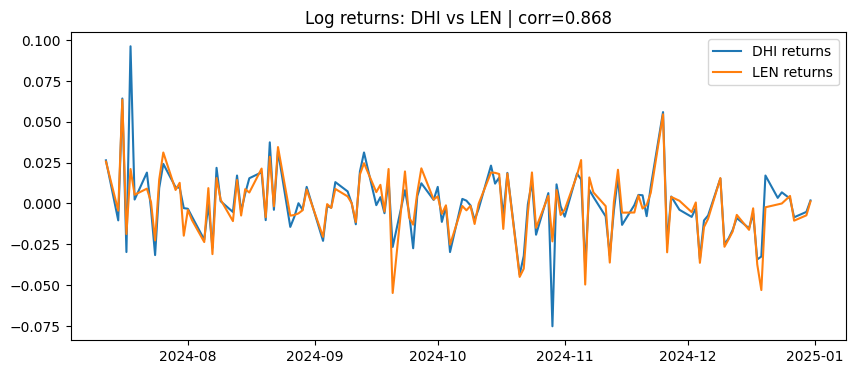

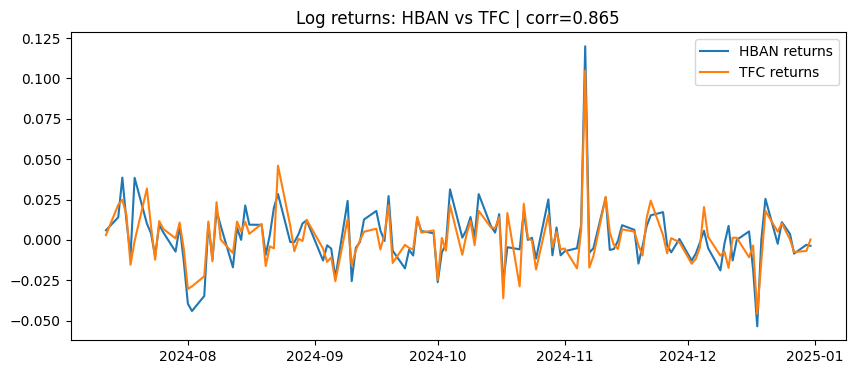

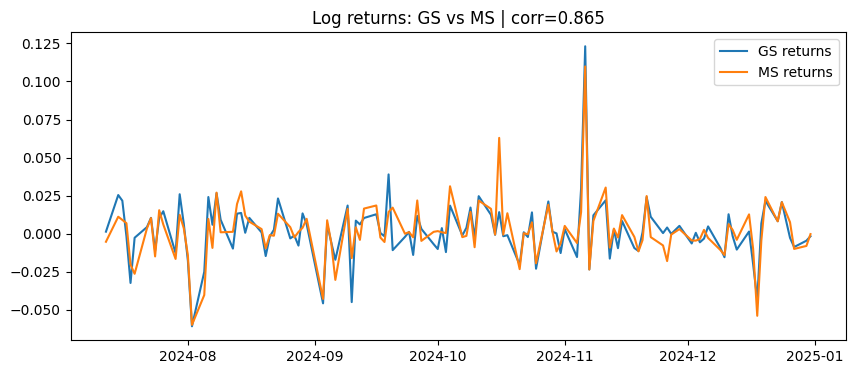

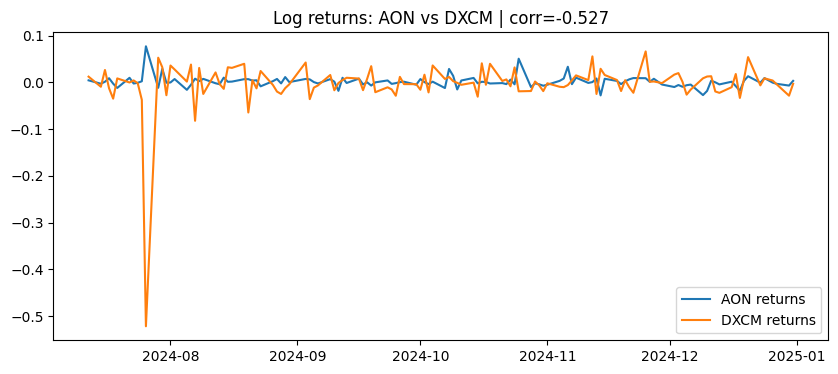

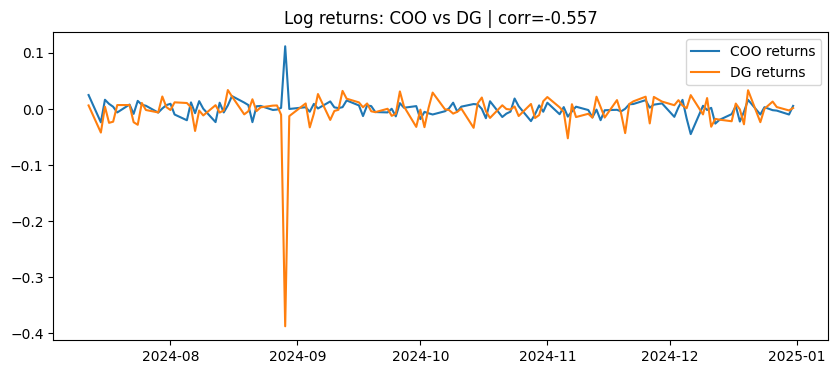

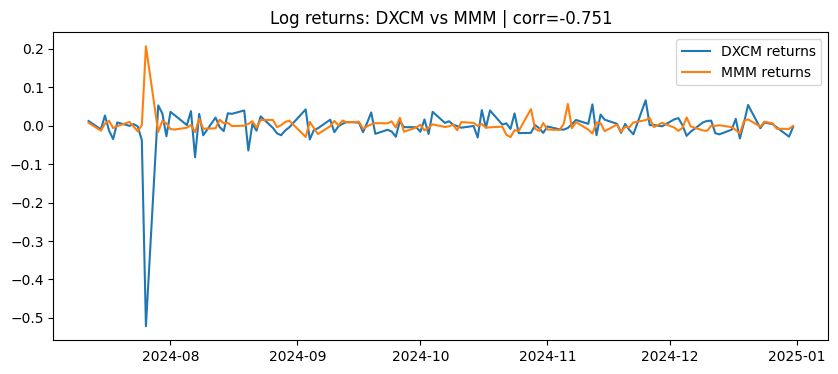

In [71]:
plot_pair_returns(closes, candidates, n_head=3, n_tail=3, window=120)


## Hedge Ratio & Spread

## OU Check

## Signals & Sizing

## Cost and Execution

## Walk-Forard Backtest

## Results

## Factor Neautrality

## Sensitivity Sweeps

## Regime Splits

## OOS Holdout

## Beta Stability

## Structural Breaks

## Cost Stress Test

## ML Ranker for Pairs

## Intraday Extensions